In [1]:
#Importing basics libraries
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew
from scipy.stats import boxcox_normmax

Loading the train and test set as pandas data frame

In [2]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In the table above, we have some basic statistics for the features, as for example the mean, the standard deviation, etc.

In [3]:
print ("Size of train data : {}" .format(train.shape))
print ("Size of test data : {}" .format(test.shape))

Size of train data : (1460, 81)
Size of test data : (1459, 80)


The number of sample for train and test is almost the same.
Notice that in the training set we have 1 more "feature" than in the test set. This because the SalePrice (which is actually the labels), is not supplied for the test set.

In [4]:
#Save the 'Id' column for creating the csv file at the end
train_ID = train['Id']
test_ID = test['Id']

#Now drop the 'Id' colum since it's not an actual feature
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#### Now, we want to check the correlation between features. A there is a lot of features, we chose the features such that their correlation with SalePrice is greater than 0.45

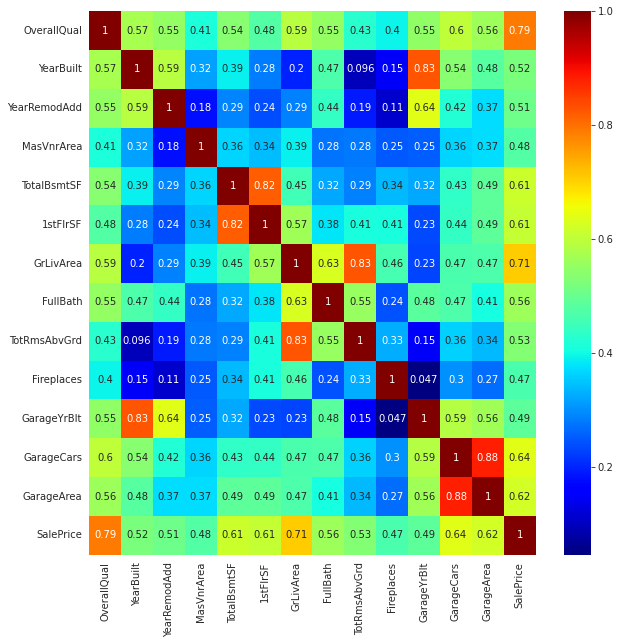

In [5]:
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.45]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="jet")

We see that OverallQual is the most correlated feature with SalePrice, and this is make sense. The GrLivArea is the second most correlated feature with SalePrice.
In addition we observed that GarageArea and GarageCars are very correlated, TotRmsAbvGrd and GrLivArea are correlated, and also GarageYrBlt and YearBuilt.

Scatter plots between 'SalePrice' and correlated variables

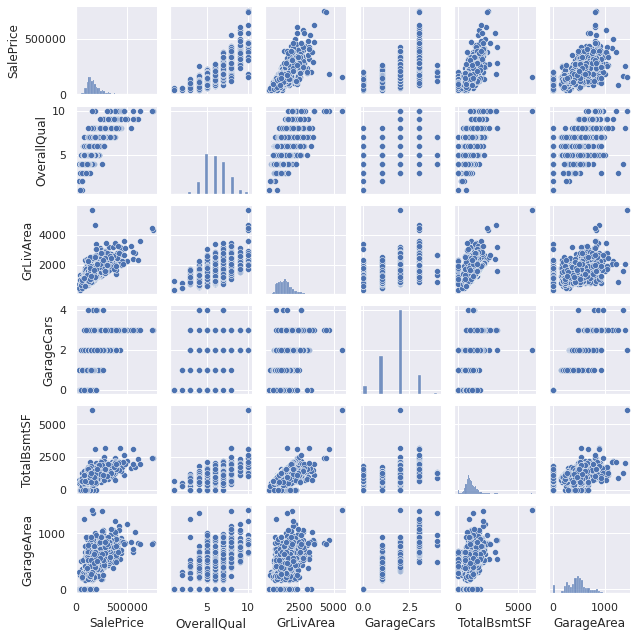

In [6]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'GarageArea']
sns.pairplot(train[cols], size = 1.5)
plt.show()

We can observe some outliers in the scatter plot of GrLivArea VS SalePrice. So, we will remove it, but first lets visualize this outliers

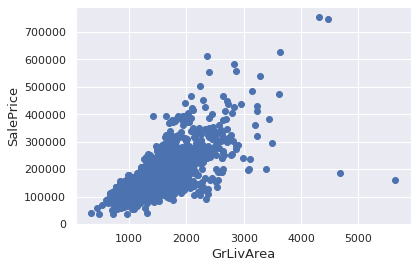

In [7]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [8]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

We can clearly see that for GrLivArea > 4000, there are two SalePrices which are extremely small. This seems ireasonable, so we will remove them.

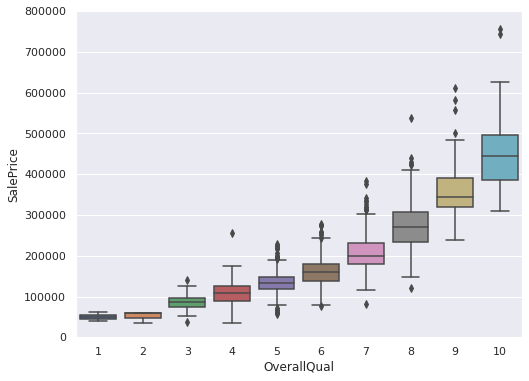

In [9]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=train['OverallQual'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

## Target variable engineering

Let's look at the histogram of the target variable "SalePrice", and compare it to a normal distribution with SalePrice mean and SalePrice std


 mu = 180932.92 and sigma = 79467.79



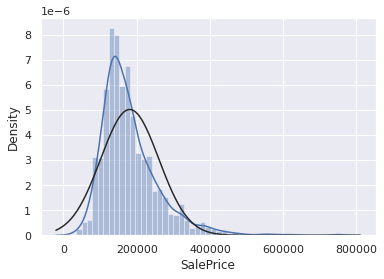

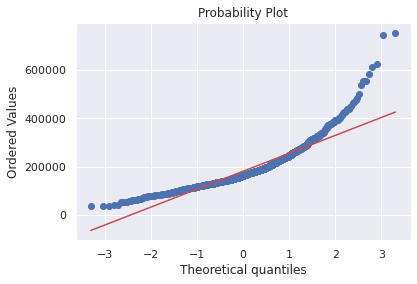

In [10]:
def check_skewness(col):
    sns.distplot(train[col] , fit=norm);
    fig = plt.figure()
    res = stats.probplot(train[col], plot=plt)
    (mu, sigma) = norm.fit(train[col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
check_skewness('SalePrice')


 mu = 180932.92 and sigma = 79467.79



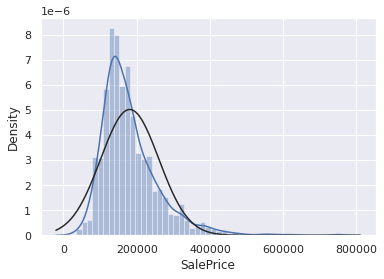

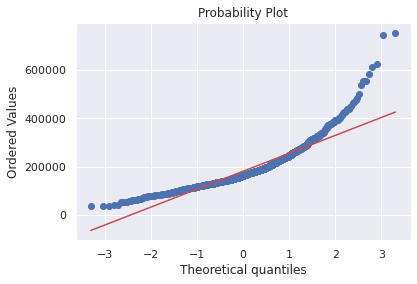

In [11]:
check_skewness('SalePrice')

We can see that SalePrice distribution is not close to normal distribution. As we learned in lectures we can conclude from the QQplot that the SalePrice distribution is positively skewed.

As LR models assume normal distributions, we will apply log transform to fix this skewness which is actuualy $log(1+x)$

In [12]:
train["SalePrice"] = np.log1p(train["SalePrice"])

Now let's look at the transformed distribution and compare it to normal distribution


 mu = 12.02 and sigma = 0.40



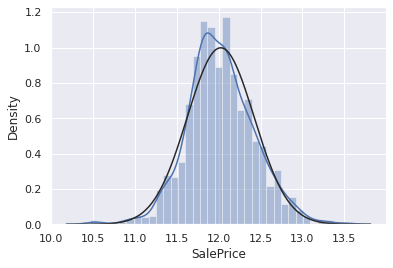

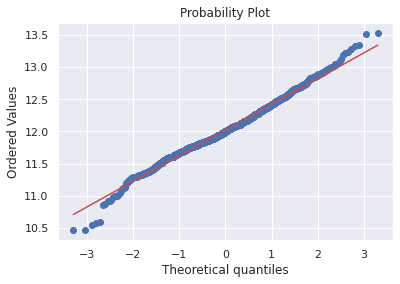

In [13]:
check_skewness('SalePrice')

We see that SalePrice disribution is now much closer to normal distribution!

# Feature Enginerring

First, we creat all_data set of both training and test set, as we want to apply the same operations on both of them.

In [14]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


## Dealing with missing data

In [15]:
#Get missing data percentages
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
#remove features with no missing values and sort
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(10)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageQual,5.450806
GarageCond,5.450806
GarageYrBlt,5.450806


We can see that PollQC has 99.69% of missing data, which means that most of the values are missing.
MiscFeatures, Alley, and Fence are also with high missing ratio.

Note that GarageFinish, GarageQual, GarageCond, GarageYrBlt has the exact same missing ratio.

Text(0.5, 1.0, 'Percentage of missing data VS Feature')

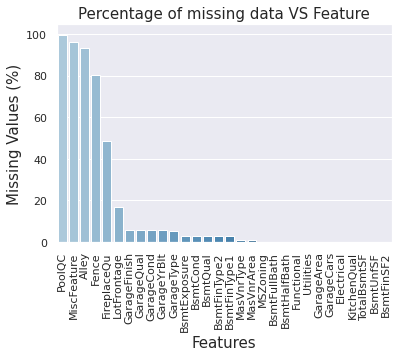

In [16]:
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na, palette="Blues_d")
plt.xlabel('Features', fontsize=15)
plt.ylabel('Missing Values (%)', fontsize=15)
plt.title('Percentage of missing data VS Feature', fontsize=15)


According to this data set documentation, some null values means that the corresponded feature does not exists. Thus, we will replace these null values with 'None'.

In [17]:
for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    all_data[col] = all_data[col].fillna('None')

fill null with zeros as no garage implies no cars

In [18]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

Using the median LotFrontage of all the neighborhood to complete its missing values.

In [19]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

missing values are zeros because null means no basement

In [20]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

The same for categorical basement features, but we have to replace nulls with 'None'

In [21]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

Same Here

In [22]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [23]:
all_data['MSZoning'].value_counts()

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

We see that the most common value is 'RL', so we will replace missing values by 'RL'
.

In [24]:
all_data['MSZoning'] = all_data['MSZoning'].fillna("RL")

For the categorical feature 'Utilities', all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.

In [25]:
print(all_data['Utilities'].value_counts())
all_data = all_data.drop(['Utilities'], axis=1)

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64


For "Functional", data description says NA means typical

In [26]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

Replacing missing categorical features with the most common value:

In [27]:
mode_col = ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in mode_col:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [28]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [29]:
all_data['OverallCond'].value_counts()

5    1643
6     531
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64

We see that there is no missing values.

Some of the non-numeric predictors are stored as numbers; convert them into strings 

In [30]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

## Labels Encoding

We have to encode some non-numerical features to numerical values because the regression algorithms usually works with numbers.
We will apply the builtin function LabelEncoder, which encodes $n$ cattegorical features to the numbers $0, 1, 2, ..., n-1$.

In [31]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


We add one more feature which is the total area of basement, first and second floor areas of each house

In [32]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

## fix features skewness

In [33]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(15)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


Now we will apply Box Cox transformation to fix skewness for numerical features that aheir absolute skewness value is larger than 0.75

We used $\lambda = 0.15$, so $BoxCox(x) = \frac{(1+x)^{\lambda}-1}{\lambda}$

In [34]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


Let's check skewness again

In [35]:
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(15)


Skew in numerical features: 



,Skew
PoolArea,15.759529
3SsnPorch,8.921650
LowQualFinSF,8.741030
MiscVal,5.594963
LandSlope,4.530264
BsmtHalfBath,3.786685
KitchenAbvGr,3.697303
ScreenPorch,2.977052
BsmtFinSF2,2.563235
EnclosedPorch,2.024321


The skewness has indded reduced

In [36]:
#one hot encoding the rest of the categorical features variables
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 220)

Recreate train and test sets

In [37]:
train = all_data[:ntrain]
test = all_data[ntrain:]
train.shape

(1458, 220)

# Build Model and Train

In [38]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor
from sklearn.cluster import KMeans

In [39]:
x_train = train.values

Create a function that calculates n_folds cross validation over the train set

In [40]:
#Cross Validation function
n_folds = 5

def rmsle_cv(model, x, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## The models 

In [41]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR, x_train, y_train)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



In [42]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso, x_train, y_train)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso score: 0.1115 (0.0074)



In [43]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet, x_train, y_train)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [44]:
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))
score = rmsle_cv(svr, x_train, y_train)
print(" SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 SVR score: 0.1127 (0.0079)



In [45]:
base_models = []
base_models.append(('ENet', ENet))
base_models.append(('svr', svr))
base_models.append(('lasso', lasso))
meta_model = KRR

## Stack Model

In [46]:
stack = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
score = rmsle_cv(stack, x_train, y_train)
print(" stack score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 stack score: 0.1099 (0.0078)



## K-Means

In [47]:
from sklearn.metrics import silhouette_score

First we want to determine what is the optimal number of clusters K.
For this we used the silhouette score.

Text(0.5, 1.0, 'Silhouette Score VS K')

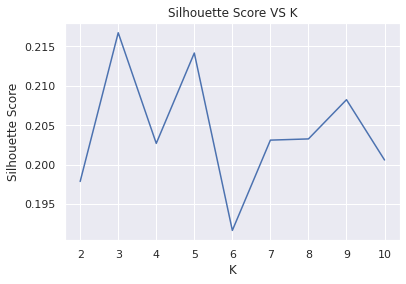

In [48]:
sil = []
kmax = 10
for k in range(2, kmax+1):
    kmeans = KMeans(n_init = 20, random_state = 1, max_iter=1000, tol = 1e-6, n_clusters = k).fit(x_train)
    labels = kmeans.labels_
    sil.append(silhouette_score(x_train, labels))

plt.plot(list(range(2, kmax+1)), sil)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score VS K')

We see that the maximal silhouette score, is for K=3. In this case, the silhouette score is 0.217. This value is considered small, which means that the data clustering is not excellent.


In [49]:
#take best K
n_clusters = 3
kmeans = KMeans(n_init = 20, n_clusters=n_clusters, random_state = 1, max_iter=1000, tol = 1e-6).fit(x_train)
all_kmeans_preds = kmeans.predict(x_train)

Now, we want to see how many sample we have in each cluster

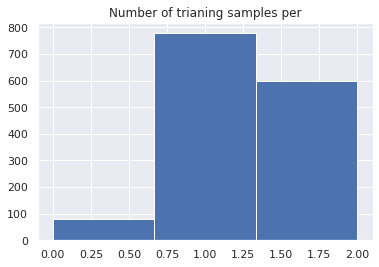

In [50]:
plt.hist(all_kmeans_preds, bins=n_clusters)
plt.title('Number of trianing samples per')
plt.show()

We see that there is a lot of samples in clusters 1, and 2, and less than 100 samples in cluster 0.

Now, we creates training set for each cluster:

In [51]:
#find indices of X_train, y_train per cluster
splitted_data = {}
for i in range(n_clusters):
    splitted_data[str(i)] = {}
    splitted_data[str(i)]['X_train'] = []
    splitted_data[str(i)]['y_train'] = []
for idx in range(len(x_train)):
     splitted_data[str(all_kmeans_preds[idx])]['X_train'].append(x_train[idx,:])
     splitted_data[str(all_kmeans_preds[idx])]['y_train'].append(y_train[idx])
for idx in range(len(x_train)):
     splitted_data[str(all_kmeans_preds[idx])]['X_train'] = np.array(splitted_data[str(all_kmeans_preds[idx])]['X_train'])
     splitted_data[str(all_kmeans_preds[idx])]['y_train'] = np.array(splitted_data[str(all_kmeans_preds[idx])]['y_train'])

Creating stack model for each cluster and check its CV score

In [52]:
stack_model_kmeans = []

for i in range(n_clusters):
    instance = clone(stack)
    score = rmsle_cv(instance, splitted_data[str(i)]['X_train'], splitted_data[str(i)]['y_train'])
    print(" cluster "+str(i)+" score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
    stack_model_i = instance.fit(splitted_data[str(i)]['X_train'], splitted_data[str(i)]['y_train'])
    stack_model_kmeans.append(stack_model_i)


 cluster 0 score: 0.2076 (0.0256)

 cluster 1 score: 0.1077 (0.0136)

 cluster 2 score: 0.1078 (0.0150)



We see that the score for cluster 0 is significantly higher with higher std than the others. These are the results that we are anticipated as in cluster 0 there is a small number of samples.

## All train data stack model

We also trained a stack model over all the train data

In [53]:
# LassoMd = lasso.fit(x_train,y_train)
# ENetMd = ENet.fit(x_train,y_train)
# KRRMd = KRR.fit(x_train,y_train)
# svrMd = svr.fit(x_train,y_train)

stack_model = stack.fit(x_train,y_train)

## Predictions

For prediction we did the follow:
1. if the test sample is from cluster 0, then use the all data model for prediction. Otherwise, use the model for the corresponded cluster.
2. Make a second prediction for each test sample using the all data model.
3. As we applied log transform over the labels, we have to apply now the inverse transform for each result in steps 1, and 2.
4. The final prediction for each sample is the average between the prediction in step 1 after applying expm1 transform and the prediction in step 2 after applying expm1 transform.

In [54]:
output1 = []
x_test = np.array(test.values)
all_kmeans_preds_test = kmeans.predict(x_test)
for i in range(len(x_test)):
    index = all_kmeans_preds_test[i]
    if index == 0:
        output1.append(stack_model.predict(x_test[i:i+1, :])[0])
    else:
        current_model = stack_model_kmeans[index]
        output1.append(current_model.predict(x_test[i:i+1, :])[0])
output2 = [(0.5*i+0.5*j) for i,j in zip(stack_model.predict(x_test), output1)]
output2 = np.expm1(output2)

## Create csv file for submission

In [55]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = output2
sub.to_csv('submission.csv',index=False)